<h2>INSTALLAZIONE LIBRERIE</h2>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Installazione librerie <strong>necessarie per il funzionamento</strong> del progetto:
</p>

In [1]:
pip install --quiet --upgrade pip scipy matplotlib wordcloud seaborn nltk scikit-learn plotly nbformat imbalanced-learn tqdm xgboost pillow tabulate

Note: you may need to restart the kernel to use updated packages.


<h2>IMPORTAZIONE LIBRERIE</h2>

In [2]:
# Calcolo e manipolazione dati
import numpy as np
import pandas as pd
from collections import Counter
import re
import string
import warnings

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)

# NLP e Preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer 
from collections import Counter

# Gestione degli squilibri di classe
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning e Modelli
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metriche di valutazione
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, log_loss, precision_recall_fscore_support, classification_report, accuracy_score, f1_score)

# Utility
from sklearn.utils import resample
from tqdm import tqdm  # Barra di avanzamento
import time

# Ignorare avvisi
warnings.filterwarnings('ignore')


<h2>ESPLORAZIONE DEI DATI (EDA)</h2>

In [3]:
# Caricamento Dataset
training_variants = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_variants.csv")
training_text = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_text.csv", sep="\|\|", engine='python', header=None, skiprows=1, names=['ID','text'])

# Stampa strutturata dei dati
print(f"{'\nDataset':<20}{'(Righe, Colonne)':<30}")
print(f"{'-'*50}")
print(f"{'Training variants':<20}{str(training_variants.shape):<30}")
print(f"{'Training text':<20}{str(training_text.shape):<30}")



Dataset            (Righe, Colonne)              
--------------------------------------------------
Training variants   (3321, 4)                     
Training text       (3321, 2)                     


In [4]:
#unione varianti e testo di addestramento 
df = pd.merge(training_variants, training_text, on = 'ID')
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


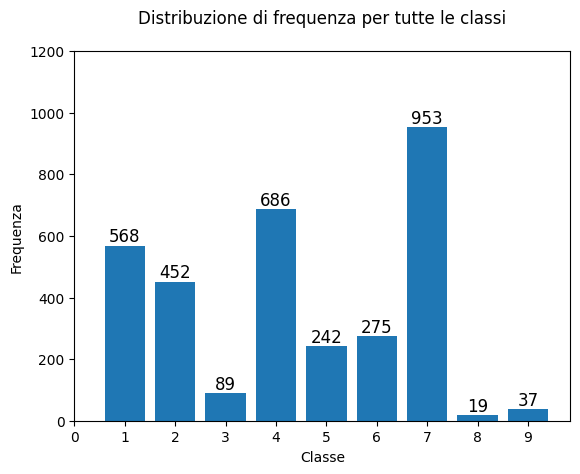

In [5]:
# Conta i valori delle classi e li ordina
plot_dist = df['Class'].value_counts().sort_index()

# Crea il grafico a barre
fig, ax = plt.subplots()

# Crea le barre
bars = ax.bar(plot_dist.index, plot_dist.values)

# Aggiungi il titolo e le etichette
ax.set_title('Distribuzione di frequenza per tutte le classi', loc='center', pad=20)
ax.set_xlabel('Classe')
ax.set_ylabel('Frequenza')

# Aggiungi i valori sopra le barre
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, yval, va='bottom', ha='center', fontsize=12)

# Imposta il limite massimo dell'asse y a 1200
ax.set_ylim(0, 1200)


# Imposta i tick dell'asse x per tutte le classi
ax.set_xticks(range(0, 10))  # Imposta tick per ogni classe

# Mostra il grafico
plt.show()



<h2>PRE-ELABORAZIONE DEL TESTO</h2>

In [6]:
from nltk.stem import PorterStemmer

# Inserimento di altre stop words manualmente adatte al contesto
custom_words = ["fig", "figure", "et", "al", "al.", "also", "data", "analyze", "study", 
                "table", "using", "method", "result", "conclusion", "author", "find", "found", "show"]

# Unione delle stop words di default + la punteggiatura + quelle aggiunte manualmente 
stop_words = set(stopwords.words('english') + list(string.punctuation) + custom_words)

# Inizializzazione dello stemmer
stemmer = PorterStemmer()

def pre_process(text):
    if isinstance(text, float):
        return ''  # Gestione di valori float
    
    text = str(text).lower().strip()
    
    # Rimozione di punteggiatura, HTML e caratteri speciali
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub(r'<.*?>+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenizzazione, rimozione stopwords e stemming
    tokens = word_tokenize(text)
    filtered_tokens = [
        stemmer.stem(word) for word in tokens 
        if word not in stop_words and not word.isdigit() and len(word) > 1  # ignora parole di lunghezza 1
    ]
    
    return ' '.join(filtered_tokens)


def process_corpus(df, text_column, class_column):
    return df.groupby(class_column).apply(lambda x: Counter(word_tokenize(pre_process(x[text_column].str.cat(sep=' ')))))

In [7]:
# Preprocessing dei dati con barra di avanzamento
print("Preprocessing dei dati...")
df['text'] = [pre_process(text) for text in tqdm(df['text'], desc="Preprocessing")]

Preprocessing dei dati...


Preprocessing: 100%|████████████████████████| 3321/3321 [03:27<00:00, 15.98it/s]


In [8]:
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,cyclin depend kinas cdk regul varieti fundamen...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evid demonstr acquir uniparent disomi a...
4,4,CBL,L399V,4,oncogen mutat monomer casita lineag lymphoma c...


In [9]:
# Cerchiamo righe con valori nulli o con la colonna 'text' vuota
df[df.isnull().any(axis=1) | (df['text'] == '')]


,ID,Gene,Variation,Class,text
1109,1109,FANCA,S1088F,1,
1277,1277,ARID5B,Truncating Mutations,1,
1407,1407,FGFR3,K508M,6,
1639,1639,FLT1,Amplification,6,
2755,2755,BRAF,G596C,7,


In [10]:
# Elimina righe con valori nulli o con campo 'text' vuoto
df = df.dropna(subset=["text"]).loc[df['text'] != '']

# Cerchiamo nuovamente righe con valori nulli o con la colonna 'text' vuota
df[df.isnull().any(axis=1) | (df['text'] == '')]


,ID,Gene,Variation,Class,text


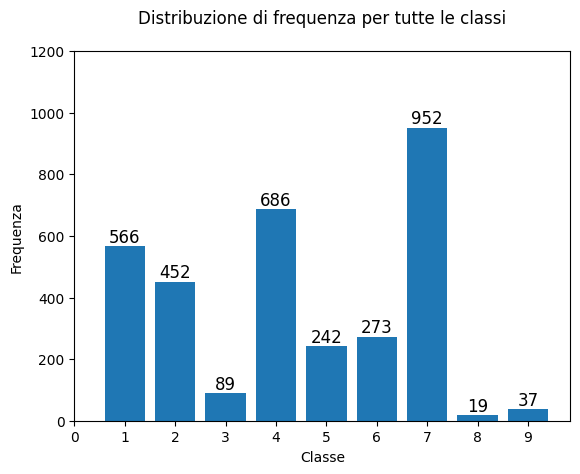

In [11]:
# Conta i valori delle classi e li ordina
plot_dist = df['Class'].value_counts().sort_index()

# Crea il grafico a barre
fig, ax = plt.subplots()

# Crea le barre
bars = ax.bar(plot_dist.index, plot_dist.values)

# Aggiungi il titolo e le etichette
ax.set_title('Distribuzione di frequenza per tutte le classi', loc='center', pad=20)
ax.set_xlabel('Classe')
ax.set_ylabel('Frequenza')

# Aggiungi i valori sopra le barre
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, yval, va='bottom', ha='center', fontsize=12)

# Imposta il limite massimo dell'asse y a 1200
ax.set_ylim(0, 1200)


# Imposta i tick dell'asse x per tutte le classi
ax.set_xticks(range(0, 10))  # Imposta tick per ogni classe

# Mostra il grafico
plt.show()


<h2>ANALISI DELLE FEATURES:</h2>

<h3> - GENI</h3>

In [12]:
unique_genes = df['Gene'].value_counts()

# Stampa del numero di geni unici
print('Numero di Geni Unici:', unique_genes.shape[0])
print(' ')
# Stampa dei top 5 geni più frequenti 
print("Top 5 Geni più frequenti:")
print(' ')
for gene, count in unique_genes.head(5).items():
    print(f'{gene}: {count}')


Numero di Geni Unici: 262
 
Top 5 Geni più frequenti:
 
BRCA1: 264
TP53: 163
EGFR: 141
PTEN: 126
BRCA2: 125


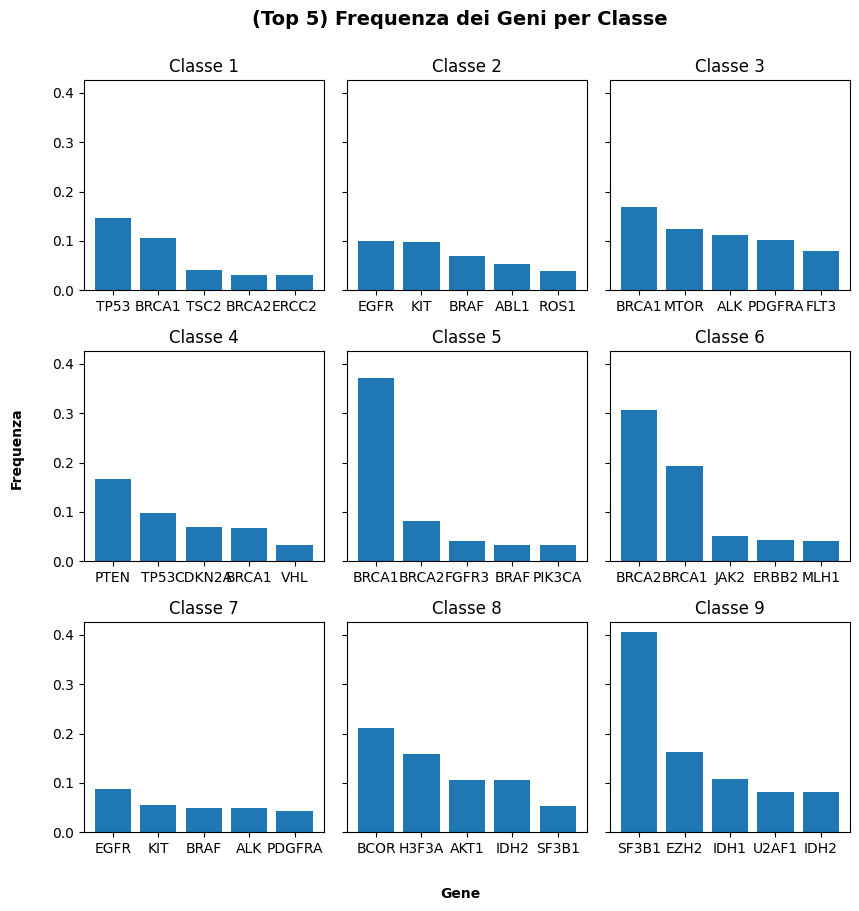

In [13]:
# Creazione dei sottotitoli per il grafico
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 9))

# Normalizzazione dei conteggi per una migliore comparazione
def normalize_group(x):
    label, repetition = x.index, x
    t = sum(repetition)
    r = [n/t for n in repetition]
    return label, r

# Creazione dei grafici per ogni classe
for idx, g in enumerate(df.groupby('Class')):
    label, val = normalize_group(g[1]["Gene"].value_counts())
    ax = axes.flat[idx]
    ax.bar(np.arange(5), val[:5], tick_label=label[:5]) 
    ax.set_title("Classe {}".format(g[0]))

# Etichette
fig.text(0.5, 0.97, '(Top 5) Frequenza dei Geni per Classe', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0, 'Gene', ha='center', fontweight='bold')
fig.text(0, 0.5, 'Frequenza', va='center', rotation='vertical', fontweight='bold')

# Ottimizzazione del layout
fig.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])


<h3> - VARIANTI</h3>

In [14]:
unique_variations = df['Variation'].value_counts()

# Stampa del numero di Varianti uniche
print('Numero di Varianti Uniche:', unique_variations.shape[0])
print(' ')

# Stampa delle top 10 Varianti più frequenti senza "name" e "dtype"
print("Top 5 Varianti più frequenti:")
print(' ')
for variation, count in unique_variations.head(10).items():
    print(f'{variation}: {count}')

Numero di Varianti Uniche: 2993
 
Top 5 Varianti più frequenti:
 
Truncating Mutations: 92
Deletion: 74
Amplification: 70
Fusions: 34
Overexpression: 6
G12V: 4
Q61L: 3
E17K: 3
T58I: 3
Q61R: 3


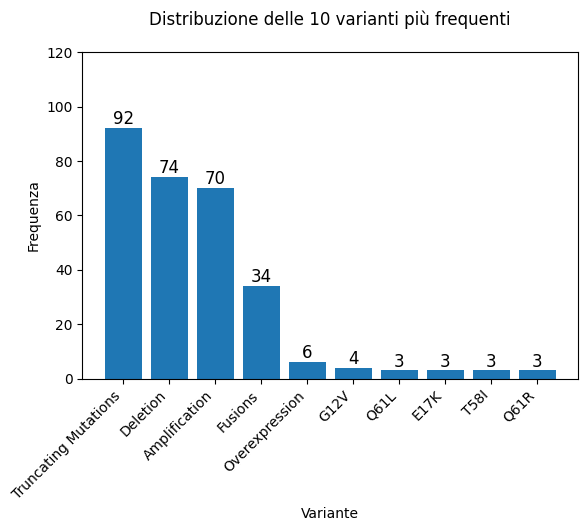

In [15]:
# Conta i valori delle varianti e prendi solo le prime 10 più frequenti
variations_data = df['Variation'].value_counts().head(10)

# Crea il grafico a barre
fig, ax = plt.subplots()

# Crea le barre
bars = ax.bar(variations_data.index, variations_data.values)

# Aggiungi il titolo e le etichette
ax.set_title('Distribuzione delle 10 varianti più frequenti', loc='center', pad=20)
ax.set_xlabel('Variante')  # Titolo dell'asse x
ax.set_ylabel('Frequenza')  # Titolo dell'asse y

# Aggiungi i valori sopra le barre
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, yval, va='bottom', ha='center', fontsize=12)

# Imposta il limite dell'asse y e i tick
ax.set_ylim(0, 120)  # Imposta il limite massimo dell'asse y a 120
ax.set_yticks(range(0, 121, 20))  # Imposta i tick dell'asse y da 0 a 120, con intervallo di 20

# Personalizzazione del font
plt.xticks(rotation=45, ha='right')  # Ruota le etichette dell'asse x se necessario
plt.subplots_adjust(bottom=0.2)  # Aggiungi spazio in basso se le etichette sono lunghe

# Mostra il grafico
plt.show()


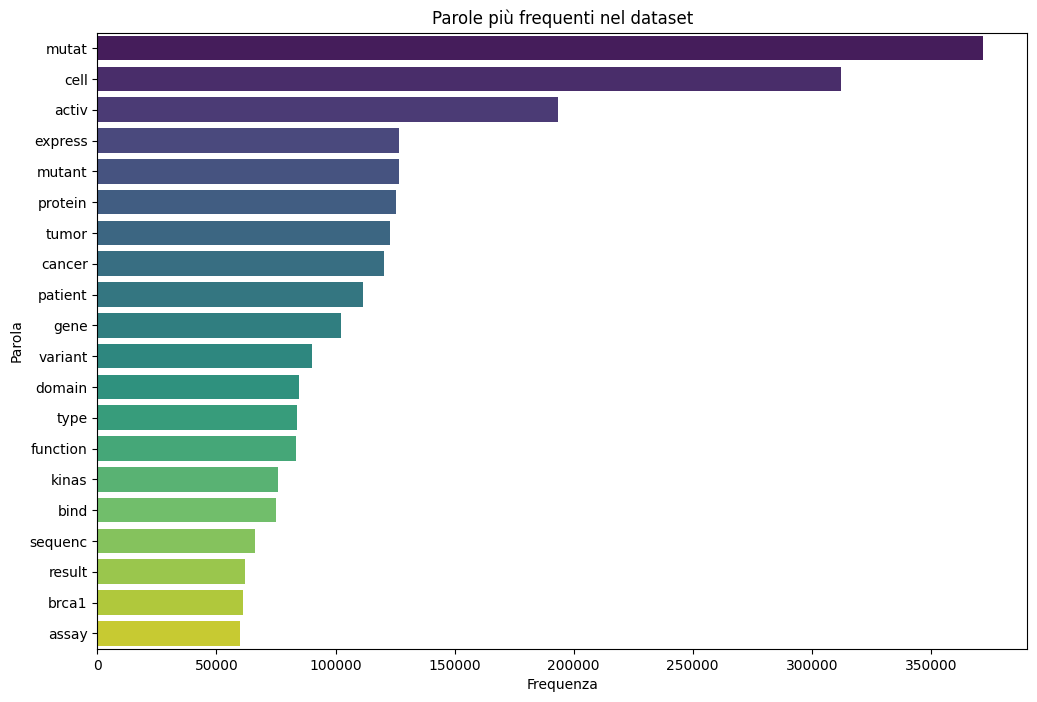

In [16]:

# Unione di tutto il testo in una singola stringa
all_text = ' '.join(df['text'].dropna())

# Tokenizzazione del testo e conteggio delle parole
tokens = all_text.split()  # Dividi il testo in parole
word_counts = Counter(tokens)  # Conta la frequenza di ogni parola

# Converti il conteggio delle parole in un DataFrame ordinato
word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

# Filtra per le parole più frequenti (ad esempio le prime 20)
top_words_df = word_freq_df.head(20)

# Crea il grafico delle parole ordinate per frequenza
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='word', x='frequency', palette='viridis')
plt.xlabel('Frequenza')
plt.ylabel('Parola')
plt.title('Parole più frequenti nel dataset')
plt.show()


<h2> MODELLAZIONE</h2>

In [41]:
def plot_class_distribution(y, title):
    # Conta e ordina i valori delle classi
    class_counts = y.value_counts().sort_index()
    
    # Crea il grafico a barre
    fig, ax = plt.subplots(figsize=(10, 5))

    # Crea le barre
    bars = ax.bar(class_counts.index, class_counts.values)

    # Aggiungi il titolo e le etichette
    ax.set_title(title, loc='center', pad=20)
    ax.set_xlabel('Classe')
    ax.set_ylabel('Frequenza')

    # Aggiungi i valori sopra le barre
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, yval, va='bottom', ha='center', fontsize=12)

    # Imposta il limite massimo dell'asse y a 1200 (o un valore adatto)
    ax.set_ylim(0, 1200)

    # Imposta i tick dell'asse x per tutte le classi
    ax.set_xticks(range(0, len(class_counts)))  # Imposta tick per ogni classe

    # Mostra il grafico
    plt.show()

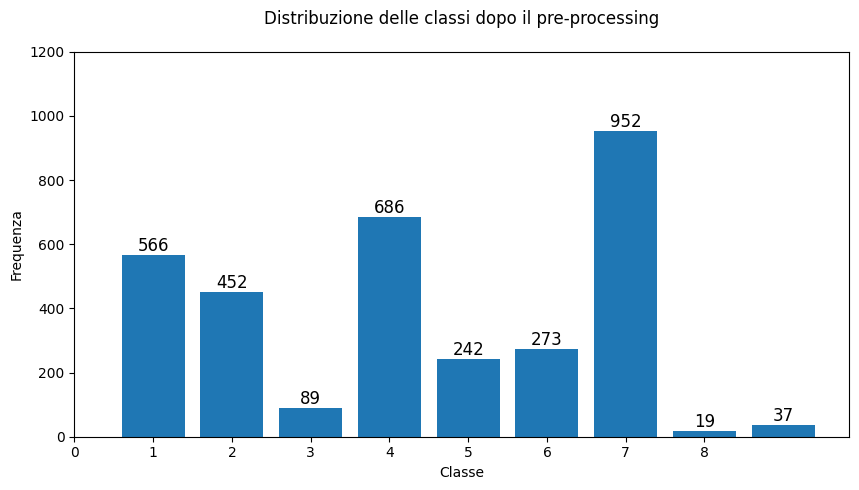

In [42]:
plot_class_distribution(df['Class'], 'Distribuzione delle classi dopo il pre-processing')

Dataset bilanciato con RandomOverSampler.
Dataset bilanciato: 8568 righe, 2 colonne


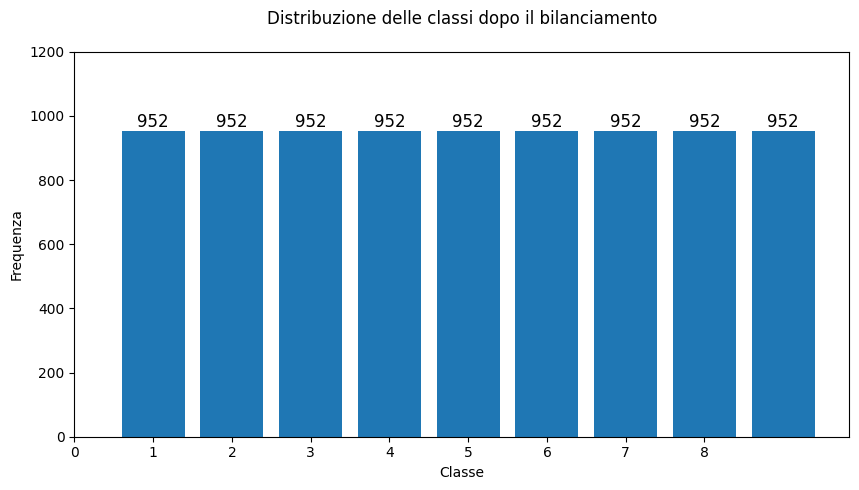

In [43]:
# Separazione delle feature e del target
X = df['text']
y = df['Class']

# Bilanciamento del dataset
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)

# Conversione in DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=['text'])
df_resampled['Class'] = y_resampled
print("Dataset bilanciato con RandomOverSampler.")
print(f"Dataset bilanciato: {df_resampled.shape[0]} righe, {df_resampled.shape[1]} colonne")
plot_class_distribution(df_resampled['Class'], 'Distribuzione delle classi dopo il bilanciamento')

In [44]:
# Applicazione di TF-IDF e SVD sul dataset non bilanciato
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['text'])
svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X_tfidf)
print("Applicazione di TF-IDF e SVD completata sul dataset non bilanciato.")
print(f"Forma della matrice TF-IDF non bilanciata: {X_tfidf.shape}")
print(f"Forma della matrice SVD non bilanciata: {X_svd.shape}\n")

# Applicazione di TF-IDF e SVD sul dataset bilanciato
tfidf_resampled = TfidfVectorizer(max_features=5000)
X_tfidf_resampled = tfidf_resampled.fit_transform(df_resampled['text'])
svd_resampled = TruncatedSVD(n_components=100, random_state=42)
X_svd_resampled = svd_resampled.fit_transform(X_tfidf_resampled)
print("Applicazione di TF-IDF e SVD completata sul dataset bilanciato.")
print(f"Forma della matrice TF-IDF bilanciata: {X_tfidf_resampled.shape}")
print(f"Forma della matrice SVD bilanciata: {X_svd_resampled.shape}")

Applicazione di TF-IDF e SVD completata sul dataset non bilanciato.
Forma della matrice TF-IDF non bilanciata: (3316, 5000)
Forma della matrice SVD non bilanciata: (3316, 100)

Applicazione di TF-IDF e SVD completata sul dataset bilanciato.
Forma della matrice TF-IDF bilanciata: (8568, 5000)
Forma della matrice SVD bilanciata: (8568, 100)


In [47]:
# Divisione del dataset non bilanciato in train e test
X_train, X_test, y_train, y_test = train_test_split(X_svd, y, test_size=0.2, random_state=42)
print("Dataset non bilanciato diviso in train e test.")
print(f"Forma di X_train non bilanciato: {X_train.shape}")
print(f"Forma di X_test non bilanciato: {X_test.shape}")
print()  # Spazio tra i risultati

# Divisione del dataset bilanciato in train e test
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_svd_resampled, y_resampled, test_size=0.2, random_state=42)
print("Dataset bilanciato diviso in train e test.")
print(f"Forma di X_train bilanciato: {X_train_resampled.shape}")
print(f"Forma di X_test bilanciato: {X_test_resampled.shape}")
print()  # Spazio tra i risultati


Dataset non bilanciato diviso in train e test.
Forma di X_train non bilanciato: (2652, 100)
Forma di X_test non bilanciato: (664, 100)

Dataset bilanciato diviso in train e test.
Forma di X_train bilanciato: (6854, 100)
Forma di X_test bilanciato: (1714, 100)



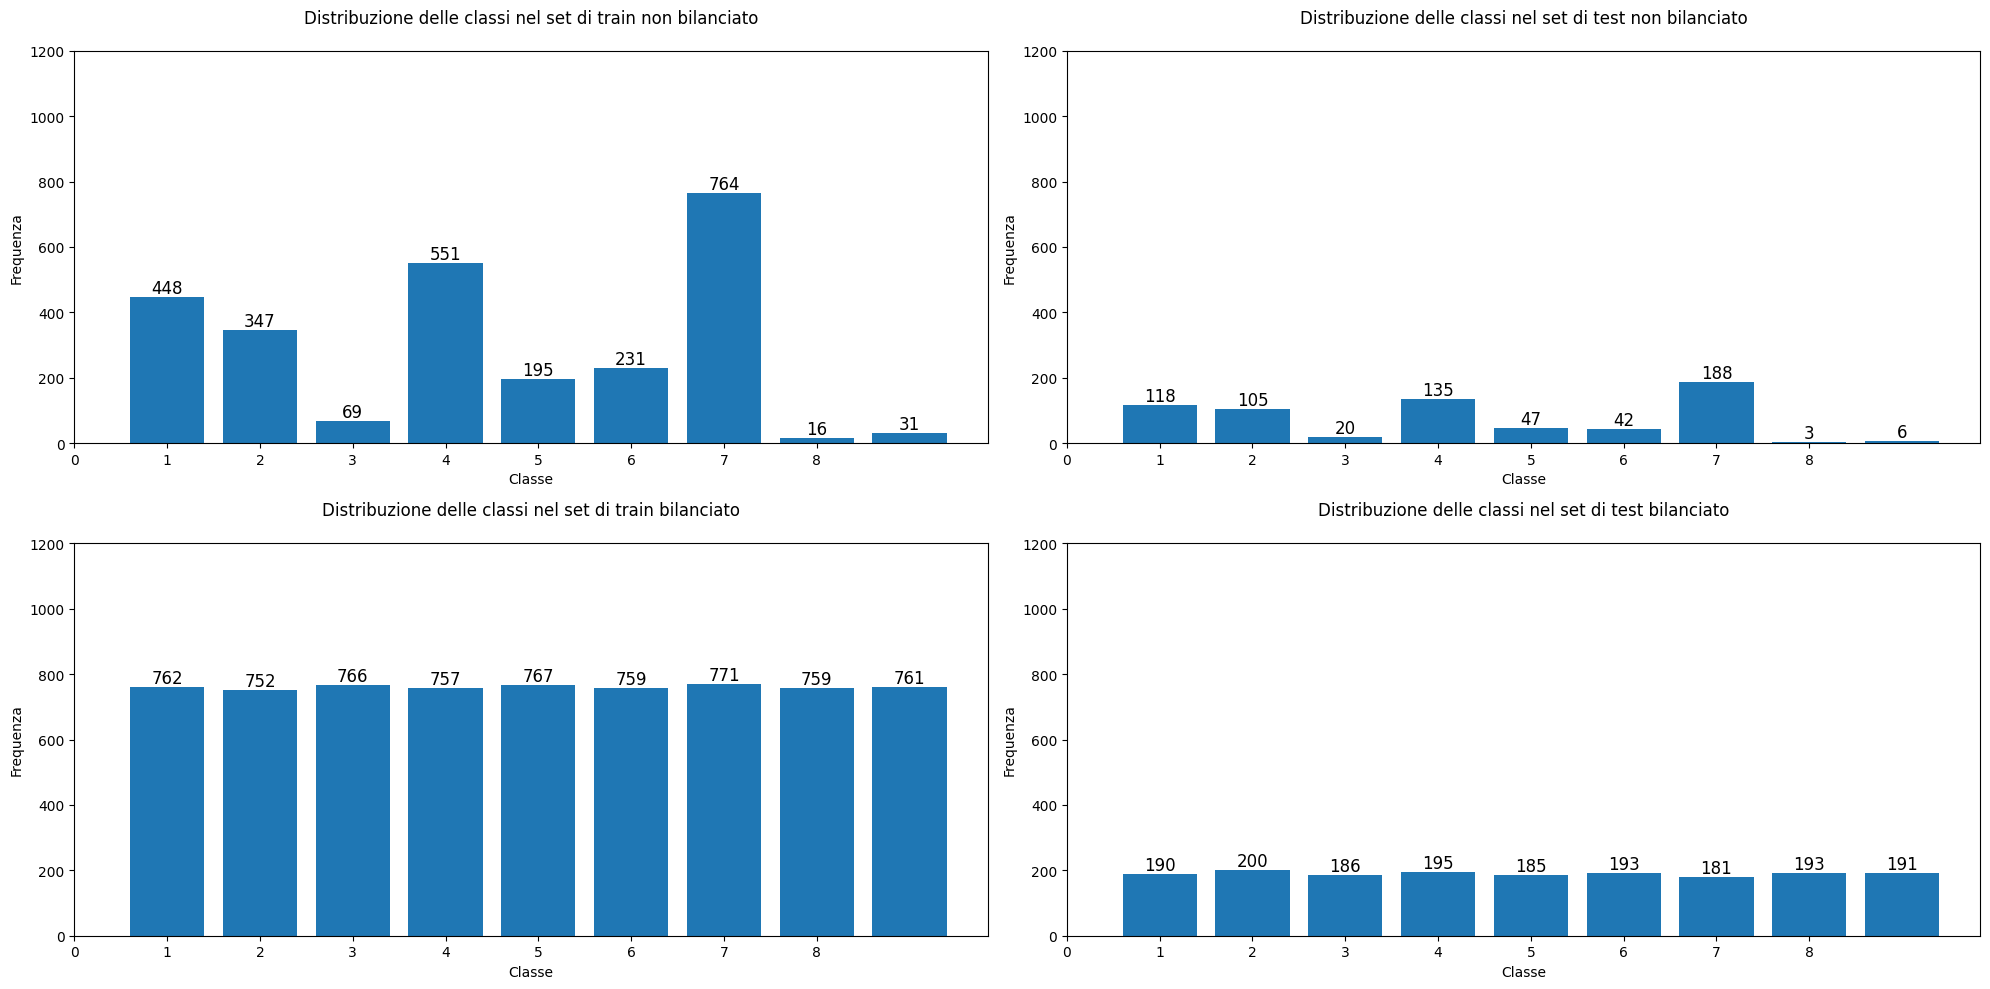

In [79]:
# Visualizzazione della distribuzione delle classi

# Creazione dei subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# Funzione per creare i grafici di distribuzione delle classi
def create_class_distribution_plot(y, ax, title):
    # Conta e ordina i valori delle classi
    class_counts = y.value_counts().sort_index()
    
    # Crea le barre
    bars = ax.bar(class_counts.index, class_counts.values)

    # Aggiungi il titolo e le etichette
    ax.set_title(title, loc='center', pad=20)
    ax.set_xlabel('Classe')
    ax.set_ylabel('Frequenza')

    # Aggiungi i valori sopra le barre
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, yval, va='bottom', ha='center', fontsize=12)

    # Imposta il limite massimo dell'asse y a 1200 (o un valore adatto)
    ax.set_ylim(0, 1200)

    # Imposta i tick dell'asse x per tutte le classi
    ax.set_xticks(range(0, len(class_counts)))  # Imposta tick per ogni classe

# Distribuzione delle classi nei set non bilanciati
create_class_distribution_plot(y_train, axes[0, 0], title="Distribuzione delle classi nel set di train non bilanciato")
create_class_distribution_plot(y_test, axes[0, 1], title="Distribuzione delle classi nel set di test non bilanciato")

# Distribuzione delle classi nei set bilanciati
create_class_distribution_plot(y_train_resampled, axes[1, 0], title="Distribuzione delle classi nel set di train bilanciato")
create_class_distribution_plot(y_test_resampled, axes[1, 1], title="Distribuzione delle classi nel set di test bilanciato")

# Mostra il grafico
plt.tight_layout()
plt.show()

In [55]:
from sklearn.model_selection import KFold, cross_val_score

def train_model(model, X_train, y_train, dataset_type):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    if isinstance(model, XGBClassifier):
        # Mappatura temporanea delle classi per XGBoost
        y_train_mapped = y_train - 1
        cv_precision = cross_val_score(model, X_train, y_train_mapped, cv=kfold, scoring='precision_macro')
        cv_recall = cross_val_score(model, X_train, y_train_mapped, cv=kfold, scoring='recall_macro')
        cv_f1 = cross_val_score(model, X_train, y_train_mapped, cv=kfold, scoring='f1_macro')
        cv_accuracy = cross_val_score(model, X_train, y_train_mapped, cv=kfold, scoring='accuracy')
    else:
        cv_precision = cross_val_score(model, X_train, y_train, cv=kfold, scoring='precision_macro')
        cv_recall = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall_macro')
        cv_f1 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_macro')
        cv_accuracy = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    
    results = {
        'Precision': cv_precision.mean(),
        'Recall': cv_recall.mean(),
        'F1': cv_f1.mean(),
        'Accuracy': cv_accuracy.mean()
    }
    
    print()
    print(f"Precision: {cv_precision.mean():.4f}")
    print(f"Recall: {cv_recall.mean():.4f}")
    print(f"F1: {cv_f1.mean():.4f}")
    print(f"Accuracy: {cv_accuracy.mean():.4f}")
    print("-" * 40)
    

In [56]:

# Definizione del modello
model = RandomForestClassifier(random_state=42)

# Esecuzione per il dataset non bilanciato
print("Risultati per Random Forest su dataset non bilanciato:")
train_model(model, X_train, y_train, 'non bilanciato')

# Esecuzione per il dataset bilanciato
print("Risultati per Random Forest su dataset bilanciato:")
train_model(model, X_train_resampled, y_train_resampled, 'bilanciato')

Risultati per Random Forest su dataset non bilanciato:

Precision: 0.5986
Recall: 0.5191
F1: 0.5399
Accuracy: 0.6501
----------------------------------------
Risultati per Random Forest su dataset bilanciato:

Precision: 0.8396
Recall: 0.8410
F1: 0.8388
Accuracy: 0.8413
----------------------------------------


In [57]:
# Definizione del modello
model = KNeighborsClassifier()

# Esecuzione per il dataset non bilanciato
print("Risultati per KNN su dataset non bilanciato:")
train_model(model, X_train, y_train, 'non bilanciato')

# Esecuzione per il dataset bilanciato
print("Risultati per KNN su dataset bilanciato:")
train_model(model, X_train_resampled, y_train_resampled, 'bilanciato')

Risultati per KNN su dataset non bilanciato:

Precision: 0.4930
Recall: 0.4447
F1: 0.4580
Accuracy: 0.5698
----------------------------------------
Risultati per KNN su dataset bilanciato:

Precision: 0.7512
Recall: 0.7523
F1: 0.7480
Accuracy: 0.7521
----------------------------------------


In [58]:
# Definizione del modello
model = LogisticRegression(random_state=42)

# Esecuzione per il dataset non bilanciato
print("Risultati per Logistic Regression su dataset non bilanciato:")
train_model(model, X_train, y_train, 'non bilanciato')

# Esecuzione per il dataset bilanciato
print("Risultati per Logistic Regression su dataset bilanciato:")
train_model(model, X_train_resampled, y_train_resampled, 'bilanciato')

Risultati per Logistic Regression su dataset non bilanciato:

Precision: 0.4639
Recall: 0.3782
F1: 0.3937
Accuracy: 0.5732
----------------------------------------
Risultati per Logistic Regression su dataset bilanciato:

Precision: 0.6465
Recall: 0.6471
F1: 0.6440
Accuracy: 0.6466
----------------------------------------


In [59]:
# Definizione del modello
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Esecuzione per il dataset non bilanciato
print("Risultati per XGBoost su dataset non bilanciato:")
train_model(model, X_train, y_train, 'non bilanciato')

# Esecuzione per il dataset bilanciato
print("Risultati per XGBoost su dataset bilanciato:")
train_model(model, X_train_resampled, y_train_resampled, 'bilanciato')

Risultati per XGBoost su dataset non bilanciato:

Precision: 0.5878
Recall: 0.5193
F1: 0.5397
Accuracy: 0.6456
----------------------------------------
Risultati per XGBoost su dataset bilanciato:

Precision: 0.8387
Recall: 0.8404
F1: 0.8382
Accuracy: 0.8404
----------------------------------------


In [65]:
def evaluate_on_test_set(model, X_train, X_test, y_train, y_test, dataset_type):
    
    if isinstance(model, XGBClassifier):
        # Mappatura temporanea delle classi per XGBoost
        y_train_mapped = y_train - 1
        y_test_mapped = y_test - 1
        # Addestramento del modello sul set di train completo
        model.fit(X_train, y_train_mapped)
        # Predizione sul set di test
        y_pred = model.predict(X_test)
        # Riconversione delle classi
        y_pred = y_pred + 1
    else:
        # Addestramento del modello sul set di train completo
        model.fit(X_train, y_train)
        # Predizione sul set di test
        y_pred = model.predict(X_test)
    
    # Calcolo delle metriche
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    
    print()
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("-" * 40)
    

In [66]:
from sklearn.ensemble import RandomForestClassifier

# Definizione del modello
model = RandomForestClassifier(random_state=42)

# Esecuzione per il dataset non bilanciato
print("Risultati per Random Forest su dataset di test non bilanciato:")
evaluate_on_test_set(model, X_train, X_test, y_train, y_test, 'non bilanciato')

# Esecuzione per il dataset bilanciato
print("Risultati per Random Forest su dataset di test bilanciato:")
evaluate_on_test_set(model, X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled, 'bilanciato')

Risultati per Random Forest su dataset di test non bilanciato:

Precision: 0.5450
Recall: 0.5146
F1: 0.5236
Accuracy: 0.6265
----------------------------------------
Risultati per Random Forest su dataset di test bilanciato:

Precision: 0.8522
Recall: 0.8545
F1: 0.8526
Accuracy: 0.8547
----------------------------------------


In [67]:
from sklearn.neighbors import KNeighborsClassifier

# Definizione del modello
model = KNeighborsClassifier()

# Esecuzione per il dataset non bilanciato
print("Risultati per KNN su dataset di test non bilanciato:")
evaluate_on_test_set(model, X_train, X_test, y_train, y_test, 'non bilanciato')

# Esecuzione per il dataset bilanciato
print("Risultati per KNN su dataset di test bilanciato:")
evaluate_on_test_set(model, X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled, 'bilanciato')

Risultati per KNN su dataset di test non bilanciato:

Precision: 0.5715
Recall: 0.5260
F1: 0.5407
Accuracy: 0.5979
----------------------------------------
Risultati per KNN su dataset di test bilanciato:

Precision: 0.7859
Recall: 0.7864
F1: 0.7841
Accuracy: 0.7870
----------------------------------------


In [68]:
from sklearn.linear_model import LogisticRegression

# Definizione del modello
model = LogisticRegression(random_state=42)

# Esecuzione per il dataset non bilanciato
print("Risultati per Logistic Regression su dataset di test non bilanciato:")
evaluate_on_test_set(model, X_train, X_test, y_train, y_test, 'non bilanciato')

# Esecuzione per il dataset bilanciato
print("Risultati per Logistic Regression su dataset di test bilanciato:")
evaluate_on_test_set(model, X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled, 'bilanciato')

Risultati per Logistic Regression su dataset di test non bilanciato:

Precision: 0.4804
Recall: 0.3691
F1: 0.3905
Accuracy: 0.5542
----------------------------------------
Risultati per Logistic Regression su dataset di test bilanciato:

Precision: 0.6694
Recall: 0.6695
F1: 0.6669
Accuracy: 0.6704
----------------------------------------


In [69]:
from xgboost import XGBClassifier

# Definizione del modello
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Esecuzione per il dataset non bilanciato
print("Risultati per XGBoost su dataset di test non bilanciato:")
evaluate_on_test_set(model, X_train, X_test, y_train, y_test, 'non bilanciato')

# Esecuzione per il dataset bilanciato
print("Risultati per XGBoost su dataset di test bilanciato:")
evaluate_on_test_set(model, X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled, 'bilanciato')

Risultati per XGBoost su dataset di test non bilanciato:

Precision: 0.5571
Recall: 0.5214
F1: 0.5312
Accuracy: 0.6386
----------------------------------------
Risultati per XGBoost su dataset di test bilanciato:

Precision: 0.8592
Recall: 0.8609
F1: 0.8593
Accuracy: 0.8611
----------------------------------------


In [72]:
def plot_confusion_matrix(model, X_test, y_test, y_pred, dataset_type, ax):
    # Calcolo della matrice di confusione
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualizzazione della matrice di confusione
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"{model.__class__.__name__} - {dataset_type}")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

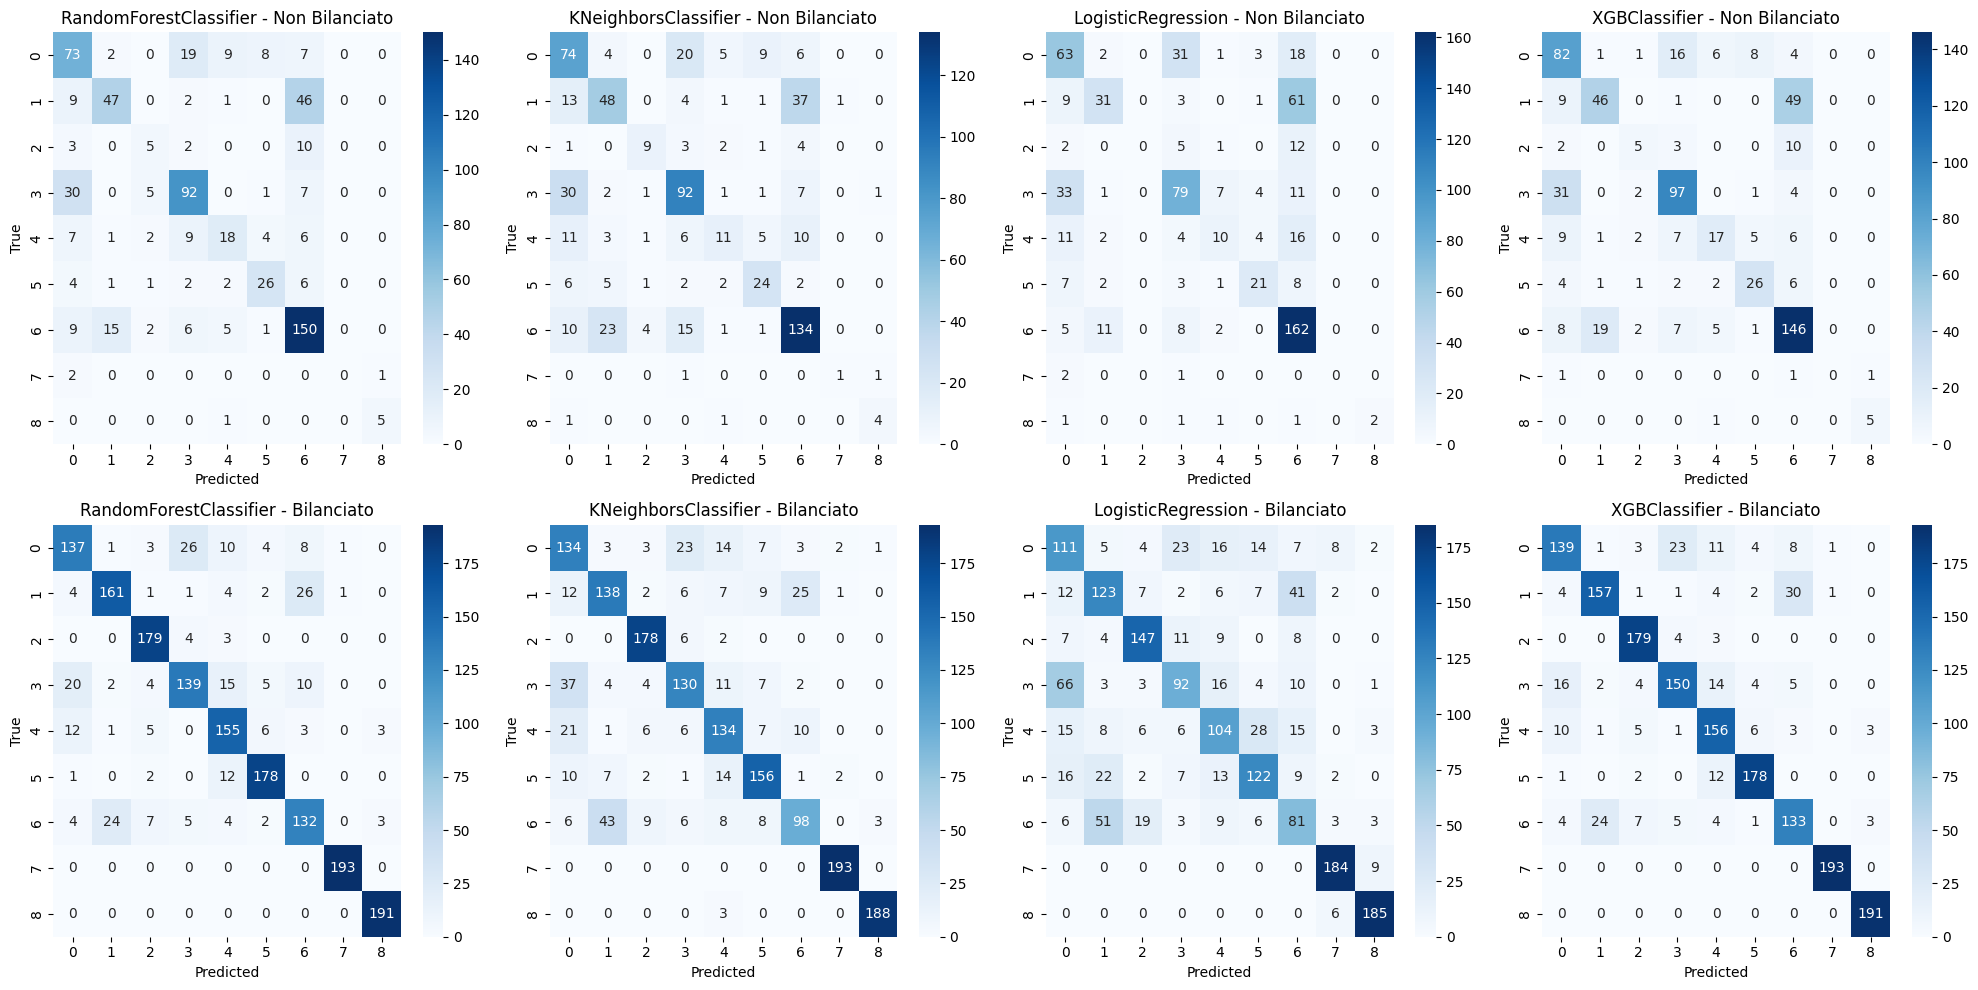

In [73]:
# Definizione dei modelli
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Creazione di una figura con due righe e quattro colonne per le matrici di confusione
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Visualizzazione delle matrici di confusione per il dataset non bilanciato
for i, (name, model) in enumerate(models.items()):
    if name == 'XGBoost':
        # Mappatura temporanea delle classi per XGBoost
        y_train_mapped = y_train - 1
        y_test_mapped = y_test - 1
        # Addestramento del modello sul set di train completo
        model.fit(X_train, y_train_mapped)
        # Predizione sul set di test
        y_pred = model.predict(X_test)
        # Riconversione delle classi
        y_pred = y_pred + 1
    else:
        # Addestramento del modello sul set di train completo
        model.fit(X_train, y_train)
        # Predizione sul set di test
        y_pred = model.predict(X_test)
    
    plot_confusion_matrix(model, X_test, y_test, y_pred, 'Non Bilanciato', axes[0, i])

# Visualizzazione delle matrici di confusione per il dataset bilanciato
for i, (name, model) in enumerate(models.items()):
    if name == 'XGBoost':
        # Mappatura temporanea delle classi per XGBoost
        y_train_resampled_mapped = y_train_resampled - 1
        y_test_resampled_mapped = y_test_resampled - 1
        # Addestramento del modello sul set di train completo
        model.fit(X_train_resampled, y_train_resampled_mapped)
        # Predizione sul set di test
        y_pred = model.predict(X_test_resampled)
        # Riconversione delle classi
        y_pred = y_pred + 1
    else:
        # Addestramento del modello sul set di train completo
        model.fit(X_train_resampled, y_train_resampled)
        # Predizione sul set di test
        y_pred = model.predict(X_test_resampled)
    
    plot_confusion_matrix(model, X_test_resampled, y_test_resampled, y_pred, 'Bilanciato', axes[1, i])

# Ajustamento del layout per evitare sovrapposizioni
plt.tight_layout()
plt.show()

In [90]:
pip install --quiet tabulate

Note: you may need to restart the kernel to use updated packages.


In [95]:
from tabulate import tabulate

# Codice ANSI per il testo grassetto
bold = "\033[1m"
reset = "\033[0m"

# Funzione per formattare il testo in grassetto se necessario
def format_bold(value, is_bold):
    return f"{bold}{value}{reset}" if is_bold else f"{value}"

# Supponiamo che results_test_unbalanced e results_test_balanced siano già stati calcolati

# Creazione delle tabelle
table_unbalanced = []
table_balanced = []

# Popolazione della tabella per il dataset non bilanciato
max_f1_unbalanced = max(results_test_unbalanced[model]['F1'] for model in results_test_unbalanced)
for model, metrics in results_test_unbalanced.items():
    f1_bold = metrics['F1'] == max_f1_unbalanced
    table_unbalanced.append(["Non Bilanciato", model, format_bold(f"{metrics['F1']:.4f}", f1_bold), f"{metrics['Accuracy']:.4f}"])

# Popolazione della tabella per il dataset bilanciato
max_f1_balanced = max(results_test_balanced[model]['F1'] for model in results_test_balanced)
for model, metrics in results_test_balanced.items():
    f1_bold = metrics['F1'] == max_f1_balanced
    table_balanced.append(["Bilanciato", model, format_bold(f"{metrics['F1']:.4f}", f1_bold), f"{metrics['Accuracy']:.4f}"])

# Generazione delle stringhe di tabella
table_unbalanced_str = tabulate(table_unbalanced, headers=["Dataset", "Modello", "F1 Score", "Accuratezza"], tablefmt="grid").splitlines()
table_balanced_str = tabulate(table_balanced, headers=["Dataset", "Modello", "F1 Score", "Accuratezza"], tablefmt="grid").splitlines()

# Assicurarsi che entrambe le tabelle abbiano la stessa altezza per l'allineamento
max_height = max(len(table_unbalanced_str), len(table_balanced_str))
table_unbalanced_str.extend([" " * len(table_unbalanced_str[0])] * (max_height - len(table_unbalanced_str)))
table_balanced_str.extend([" " * len(table_balanced_str[0])] * (max_height - len(table_balanced_str)))

# Stampa delle tabelle affiancate
print("Risultati in forma tabellare:")
for line_unbalanced, line_balanced in zip(table_unbalanced_str, table_balanced_str):
    print(f"{line_unbalanced}    {line_balanced}")


Risultati in forma tabellare:
+----------------+---------------------+------------+---------------+    +------------+---------------------+------------+---------------+
| Dataset        | Modello             |   F1 Score |   Accuratezza |    | Dataset    | Modello             |   F1 Score |   Accuratezza |
+================+=====================+============+===============+    +============+=====================+============+===============+
| Non Bilanciato | Random Forest       |     0.5236 |        0.6265 |    | Bilanciato | Random Forest       |     0.8526 |        0.8547 |
+----------------+---------------------+------------+---------------+    +------------+---------------------+------------+---------------+
| Non Bilanciato | KNN                 |     0.5407 |        0.5979 |    | Bilanciato | KNN                 |     0.7841 |        0.787  |
+----------------+---------------------+------------+---------------+    +------------+---------------------+------------+--------------

In [96]:
# Codice ANSI per il testo grassetto
bold = "\033[1m"
reset = "\033[0m"

# Determinazione del miglior modello per il dataset non bilanciato
best_model_unbalanced = max(results_test_unbalanced, key=lambda k: results_test_unbalanced[k]['F1'])
best_f1_unbalanced = results_test_unbalanced[best_model_unbalanced]['F1']
best_accuracy_unbalanced = results_test_unbalanced[best_model_unbalanced]['Accuracy']

# Determinazione del miglior modello per il dataset bilanciato
best_model_balanced = max(results_test_balanced, key=lambda k: results_test_balanced[k]['F1'])
best_f1_balanced = results_test_balanced[best_model_balanced]['F1']
best_accuracy_balanced = results_test_balanced[best_model_balanced]['Accuracy']

# Stampa dei risultati con grassetto
print(f"Miglior modello per il dataset {bold}non bilanciato{reset}: {bold}{best_model_unbalanced}{reset} con F1 score: {bold}{best_f1_unbalanced:.4f}{reset} e accuratezza: {bold}{best_accuracy_unbalanced:.4f}{reset}")
print(f"Miglior modello per il dataset {bold}bilanciato{reset}: {bold}{best_model_balanced}{reset} con F1 score: {bold}{best_f1_balanced:.4f}{reset} e accuratezza: {bold}{best_accuracy_balanced:.4f}{reset}")
print()
print("-" * 40)
print()

# Confronto delle prestazioni migliori con grassetto
if best_f1_unbalanced > best_f1_balanced:
    print(f"Il miglior modello è {bold}{best_model_unbalanced}{reset} con dataset {bold}non bilanciato{reset}.")
elif best_f1_balanced > best_f1_unbalanced:
    print(f"Il miglior modello è {bold}{best_model_balanced}{reset} con dataset {bold}bilanciato{reset}.")
else:
    print(f"Entrambi i modelli hanno ottenuto le {bold}stesse prestazioni migliori{reset}.")


Miglior modello per il dataset non bilanciato: KNN con F1 score: 0.5407 e accuratezza: 0.5979
Miglior modello per il dataset bilanciato: XGBoost con F1 score: 0.8593 e accuratezza: 0.8611

----------------------------------------

Il miglior modello è XGBoost con dataset bilanciato.
